### In order to run this notebook, please ensure your data is structured as follows:

```bash
file_dir/
├── sample name/condition (1)
├    ├── key (1)
├    └── key (2)
├── sample name/condition (2)
├    ├── key (1)
├    └── key (2)
├── sample name/condition (3)
├    ├── key (1)
├    └── key (2)
└──sample name/condition (4)
     ├── key (1)
     └── key (2)
```

## For Example:
```bash
zt_visualize/
├──  Brain organoid - Control
├    ├── lipid
├    └── water (2)
└──  Brain organoid - microglia
     ├── lipid
     └── water

dependencies:
pip install git+https://github.com/NMRPy/nmrpy.git@4aeb0b738b72743900b45cfc9e7f8caaa3381b20
pip install pywt

'''

### Import packages, define functions

In [2]:
import nmrpy
import os
from matplotlib import pyplot as plt
import numpy as np
import math
import time
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib
from matplotlib import colormaps
import pywt

In [3]:
def import_data(file_dir, key):    
    init_arr = os.listdir(f"./{file_dir}/")

    exp_names = []
    for i in range(len(init_arr)):
        if("." not in init_arr[i]):
            exp_names.append(init_arr[i])

    fidarr_dict = {}
    for j in range(len(exp_names)):
        file_arr = os.listdir(f"./{file_dir}/{exp_names[j]}/{key}/")
        temp_dict = {}
        for k in range(len(file_arr)):
            if("." not in file_arr[k]):
                temp_dict[file_arr[k]] = nmrpy.from_path(fid_path=f"./{file_dir}/{exp_names[j]}/{key}/{file_arr[k]}")
        fidarr_dict[f"{exp_names[j]}"] = temp_dict

    return fidarr_dict

def preprocess(fid_array: nmrpy.data_objects.FidArray):
    start_time = time.time()
    print("EMHZ, Fourier Transform")
    em_ft(fid_array)
    print("Finished!\nPhase Correct, Real, Norm Fids:\n")
    pc(fid_array)
    print("Finished!")
    print("-- %5.5f s Run Time --" % (time.time() - start_time))

def em_ft(fid_array: nmrpy.data_objects.FidArray):
    fid_array.emhz_fids();
    fid_array.ft_fids();

def pc(fid_array: nmrpy.data_objects.FidArray):
    fid_array.phase_correct_fids(verbose = False);
    fid_array.real_fids();
    fid_array.norm_fids();

def generate_idx(n, arr):
    m = len(arr)
    out = []
    for i in range(n):
        n = str(np.random.randint(0,m))
        while(n in out):
            n = str(np.random.randint(0,m))
        s = str(n)
        while(len(s) != len(str(m))):
            s = "0" + s
        out.append(s)
    return out

def avg_spectra(fidArray: nmrpy.data_objects.FidArray, n):
    dataOut = 0
    ppmOut = 0
    indx_array = generate_idx(n, fidArray.data)
    #print(indx_array)
    for i in range(n):
        dataOut = dataOut + fidArray.get_fid(f"fid{indx_array[i]}").data
        ppmOut = ppmOut + fidArray.get_fid(f"fid{indx_array[i]}")._ppm
    dataOut = dataOut / n
    ppmOut = ppmOut / n
    return dataOut, ppmOut

def fidDictViz(dataDict):
    if type(dataDict) is dict:
        for i in dataDict.keys():
            print(f"{i}:")
            print(f"\t{fidDictViz(dataDict[i])}")
    #type(a) is nmrpy.data_objects.FidArray
        return ""
    elif type(dataDict) is np.ndarray:
        print(f"\t{dataDict}")
        return ""
    else:
        if(len(dataDict.get_fids()) > 10):
            print(f"\t{[f.id for f in dataDict.get_fids()[1:5]]}, {len(dataDict.get_fids()) - 4} keys omitted")
        else:
            print(f"\t{[f.id for f in dataDict.get_fids()]}")
        return ""

def preproc_max_inDict(dataDict):
    for i in dataDict.keys():
        tAvg = {}
        tPpm = {}
        for j in dataDict[i].keys():
            preprocess(dataDict[i][j])
            tTuple = avg_spectra(dataDict[i][j], len(dataDict[i][j].data))
            tAvg[j] = tTuple[0]
            tPpm[j] = tTuple[1]
        dataDict[i]["max_avgs"] = tAvg
        dataDict[i]["max_ppms"] = tPpm

def plotmaxDict(dataDict, samples, cmap = 'viridis'):
    map = matplotlib.colormaps[cmap].resampled(samples)
    counter = 0
    for i in dataDict.keys():
        for j in dataDict[i]["max_avgs"].keys():
            plt.plot(dataDict[i]["max_ppms"][j], dataDict[i]["max_avgs"][j],
                     c = map.colors[counter], 
                     label = f"{i}_{j}")
            counter += 1
    plt.legend()
    plt.xlim(left = -1, right = 6)


def shift_tms(fid_arr, ppm, verbose):
    pos = np.where(fid_arr == max(fid_arr))
    zero = np.where((ppm == min(abs(ppm))) | (ppm == -1 * min(abs(ppm))))
    shift = True
    if(pos != zero):
        if verbose:
            print(f"\tPosition Not Equal: \tfidpos: {pos[0][0]}\tppmpos: {zero[0][0]}, \tppm value: {ppm[zero[0][0]]}\n")
    else:
        if verbose:
            print(f"\tPosition Equal: \tfidpos: {pos[0][0]}\tppmpos: {zero[0][0]}, \tppm value: {ppm[zero[0][0]]}\n")
        shift = False
        newFID = fid_arr

    if shift:
        if verbose:
            print("\tShifting fid such that the highest frequency peak is also closest to 0\n")
        diff = zero[0][0] - pos[0][0]
        if verbose:
            print(f"\tShift amount = {diff}\n")
        if (diff > (len(fid_arr)/10)):
            if verbose:
                print("\tToo much shift. Alignment Failed\n")
            return "emp","ty"
        else:
            newFID = np.roll(fid_arr, diff)
            shift_tms(newFID, ppm, verbose = verbose)

    #set min ppm to 0
    
    ppmval = ppm[zero]

    new_ppm = ppm - ppmval

    pos = np.where(newFID == max(newFID))
    zero = np.where((new_ppm == min(abs(new_ppm))) | (new_ppm == -1 * min(abs(new_ppm))))
        
    if verbose:
        print(f"final values: \tfidpos: {pos[0][0]}\tppmpos: {zero[0][0]}, \tppm value: {new_ppm[zero[0][0]]}\n")
    
    return newFID, new_ppm

def rem_invalid_shift_dict(shift, ppmSh):
    nshift = dict(shift)
    nppmSh = dict(ppmSh)
    for i in shift.keys():
        if type(nshift[i]) == str:
            del nshift[i]
            del nppmSh[i]
    return nshift, nppmSh

def calc_shift_dict(dataDict, verbose = True):
    for i in dataDict.keys():
        tshift = {}
        tppms = {}
        for j in dataDict[i]["max_avgs"].keys():
            tTuple = (shift_tms(dataDict[i]["max_avgs"][j], dataDict[i]["max_ppms"][j], verbose = verbose))
            tshift[j] = tTuple[0]
            tppms[j] = tTuple[1]
        tshift, tppms = rem_invalid_shift_dict(tshift, tppms)
        dataDict[i]["shift"] = tshift
        dataDict[i]["ppmSh"] = tppms

def plotshiftDict(dataDict, samples, cmap = 'viridis'):
    map = matplotlib.colormaps[cmap].resampled(samples)
    counter = 0
    for i in dataDict.keys():
        for j in dataDict[i]["shift"].keys():
            plt.plot(dataDict[i]["ppmSh"][j], dataDict[i]["shift"][j],
                     c = map.colors[counter], 
                     label = f"{i}_{j}")
            counter += 1
    plt.legend()
    plt.xlim(left = -1, right = 6)


def closer_to_zero(spec, ppm):
    cond = False
    max_index = np.where(spec == max(spec))[0][0]
    if(abs(ppm[max_index]) < (1 - abs(ppm[max_index]))):
        cond = True
    return cond

def focus_ppm_region(spec, ppm):
    #truncate TMS peak and water suppression peak 
    tempSpec = np.array(spec)
    index_of_TMS = np.where(tempSpec == max(tempSpec))[0][0]
    index_of_water = np.where(tempSpec == min(spec))[0][0]
    return spec[index_of_water: index_of_TMS], ppm[index_of_water:index_of_TMS]

def repad(spec, ppm, n, max = True):
    tspec = spec
    tppm = ppm
    if max:
        if(len(tspec) < n):
            tspec = np.pad(tspec, (0, n - len(tspec)))
            tppm = np.pad(tppm, (0, n - len(tppm)))
    else:
        if(len(spec) > n):
            tspec = tspec[:(n - len(tspec))]
            tppm = tppm[:(n - len(tppm))]
    
    return tspec, tppm
        

def truncate_dict(dataDict, bymax = True):
    if(bymax):
        nlen = 0
    else:
        nlen = math.inf
    for i in dataDict.keys():
        trun = {}
        tppm = {}
        for j in dataDict[i]["shift"]:
            #print(f"Truncating shifted spectra in {j}")
            trun[j] = dataDict[i]["shift"][j]
            tppm[j] = dataDict[i]["ppmSh"][j]
            while(closer_to_zero(trun[j], tppm[j])):
                tTuple = focus_ppm_region(trun[j], tppm[j])
                trun[j] = tTuple[0]
                tppm[j] = tTuple[1]
            if(len(trun[j]) > nlen) and bymax:
                nlen = len(trun[j])
            elif(len(trun[j]) < nlen) and not bymax:
                nlen = len(trun[j])
        dataDict[i]["truncated"] = trun
        dataDict[i]["tPpm"] = tppm
    #print(nlen)

    for i in dataDict.keys():
        for k in dataDict[i]["truncated"].keys():
            dataDict[i]["truncated"][k], dataDict[i]["tPpm"][k] = repad(dataDict[i]["truncated"][k], dataDict[i]["tPpm"][k], n = nlen, max = bymax)
            #print(len(dataDict[i]["truncated"][k]), len(dataDict[i]["tPpm"][k]))

def plotTruncdict(dataDict, samples, cmap = 'viridis'):
    map = matplotlib.colormaps[cmap].resampled(samples)
    counter = 0
    for i in dataDict.keys():
        for j in dataDict[i]["truncated"].keys():
            #print(len(dataDict[i]["tPpm"][j]), len(dataDict[i]["tPpm"][j]))
            plt.plot(dataDict[i]["tPpm"][j], dataDict[i]["truncated"][j],
                     c = map.colors[counter], 
                     label = f"{i}_{j}")
            counter += 1
    plt.legend()

### Perform Processing, Analysis

In [15]:
dataDict = import_data("zt_visualize", "lipid")

Not NMRPy data file.
Attempting Bruker
Not NMRPy data file.
Attempting Bruker


In [16]:
preproc_max_inDict(dataDict)

EMHZ, Fourier Transform
Fourier-transformation completed
Finished!
Phase Correct, Real, Norm Fids:

phase-correction completed
Finished!
-- 8.96372 s Run Time --
EMHZ, Fourier Transform
Fourier-transformation completed
Finished!
Phase Correct, Real, Norm Fids:

phase-correction completed
Finished!
-- 9.26892 s Run Time --


In [9]:
waterdata = dataDict

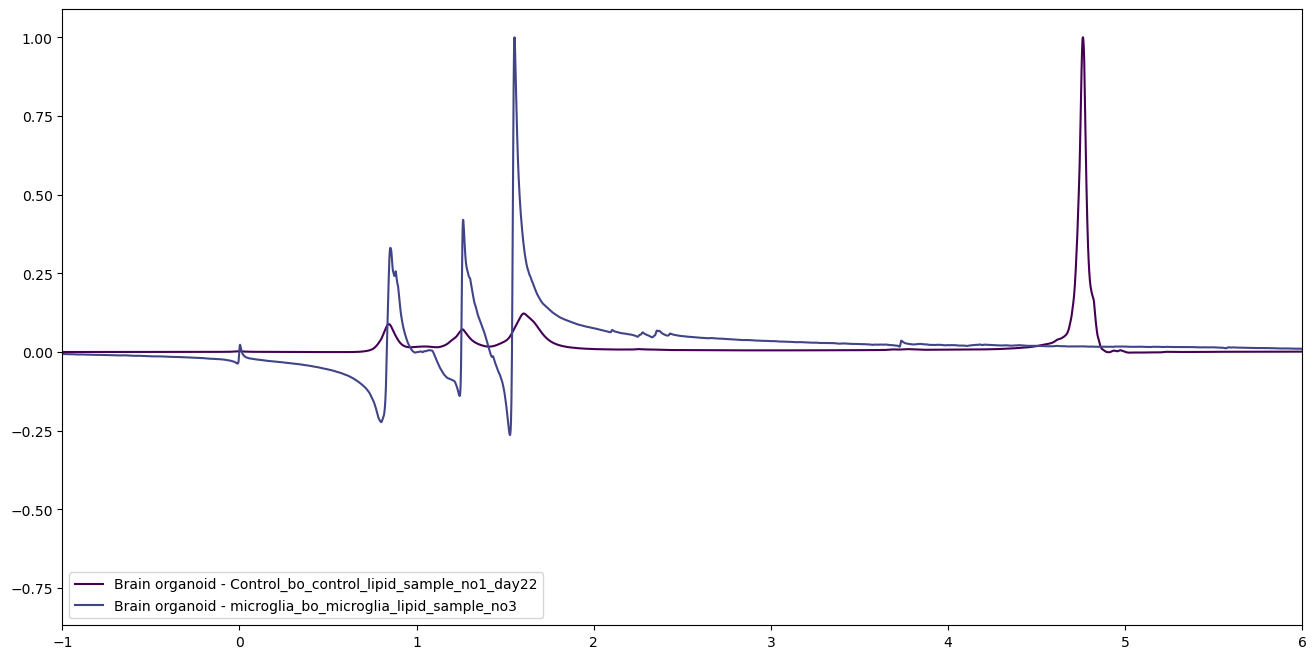

In [7]:
plt.figure(figsize=(16,8))
plotmaxDict(dataDict, 6)

In [8]:
dataDict['Brain organoid - Control']['max_avgs']
dataDict['Brain organoid - Control']['max_ppms']

{'bo_control_lipid_sample_no1_day22': array([18.05554   , 18.05503932, 18.05453864, ..., -5.74569476,
        -5.74619544, -5.74669612])}

In [17]:
calc_shift_dict(dataDict, verbose = False)

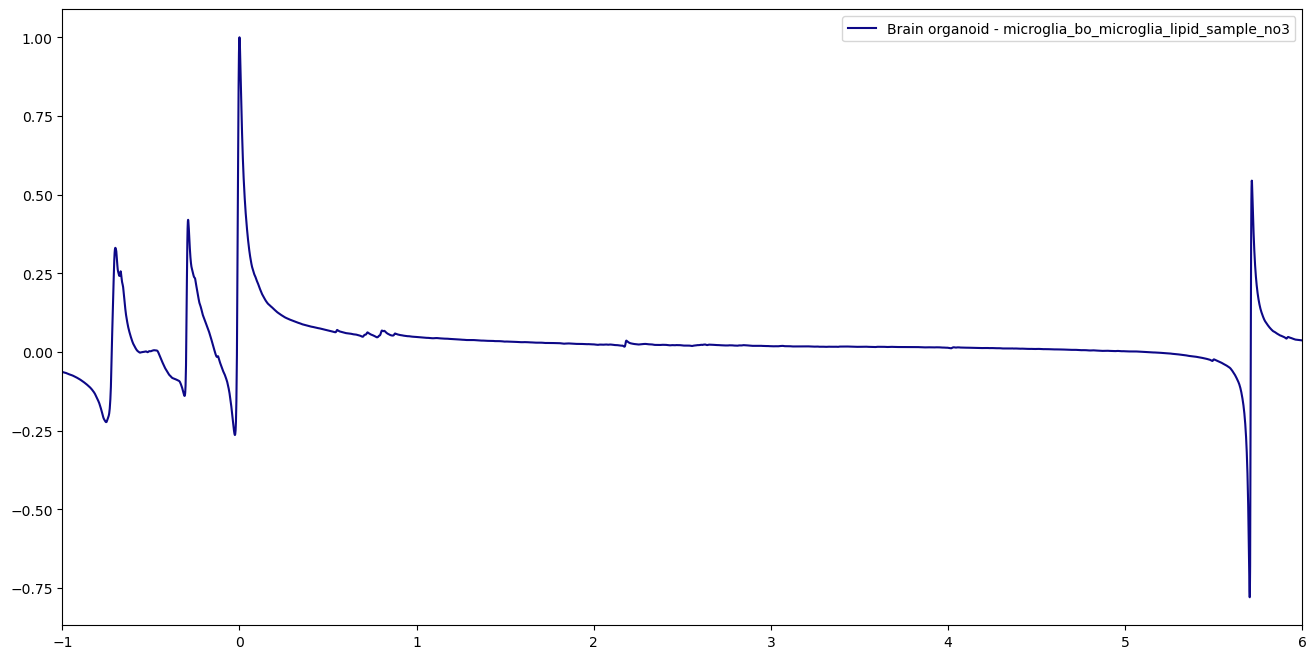

In [10]:
plt.figure(figsize=(16,8))
plotshiftDict(dataDict, 4, cmap = 'plasma')

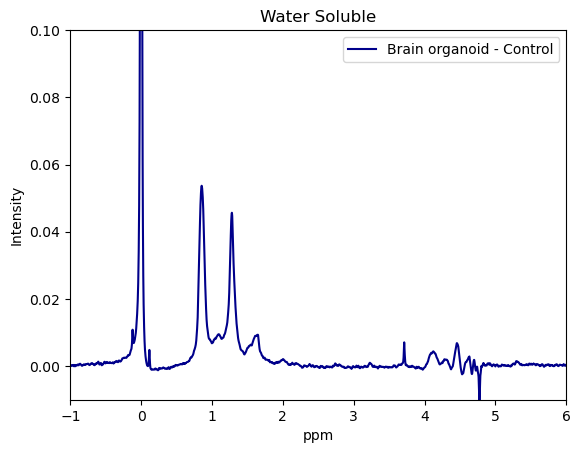

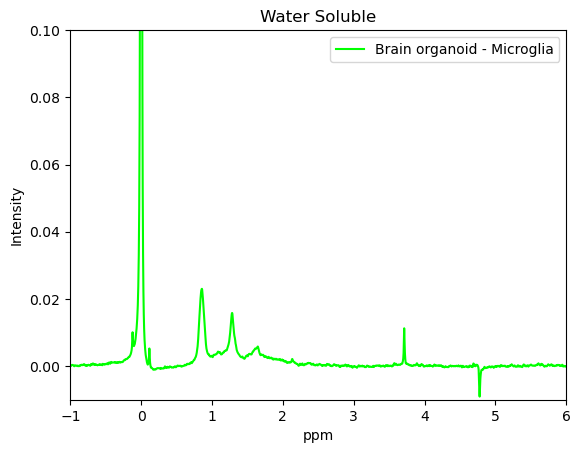

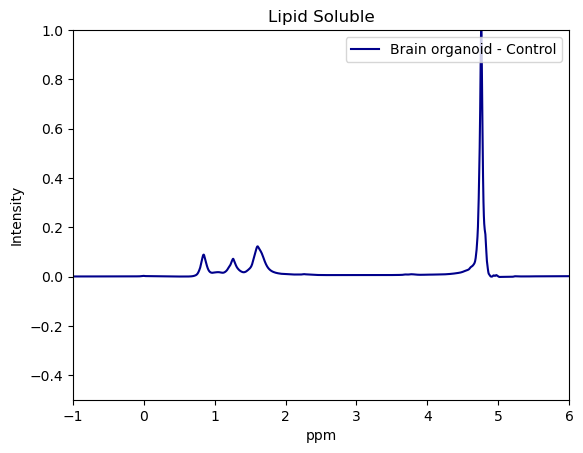

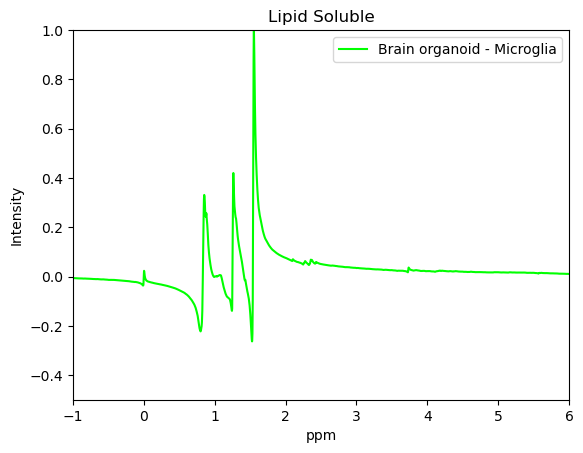

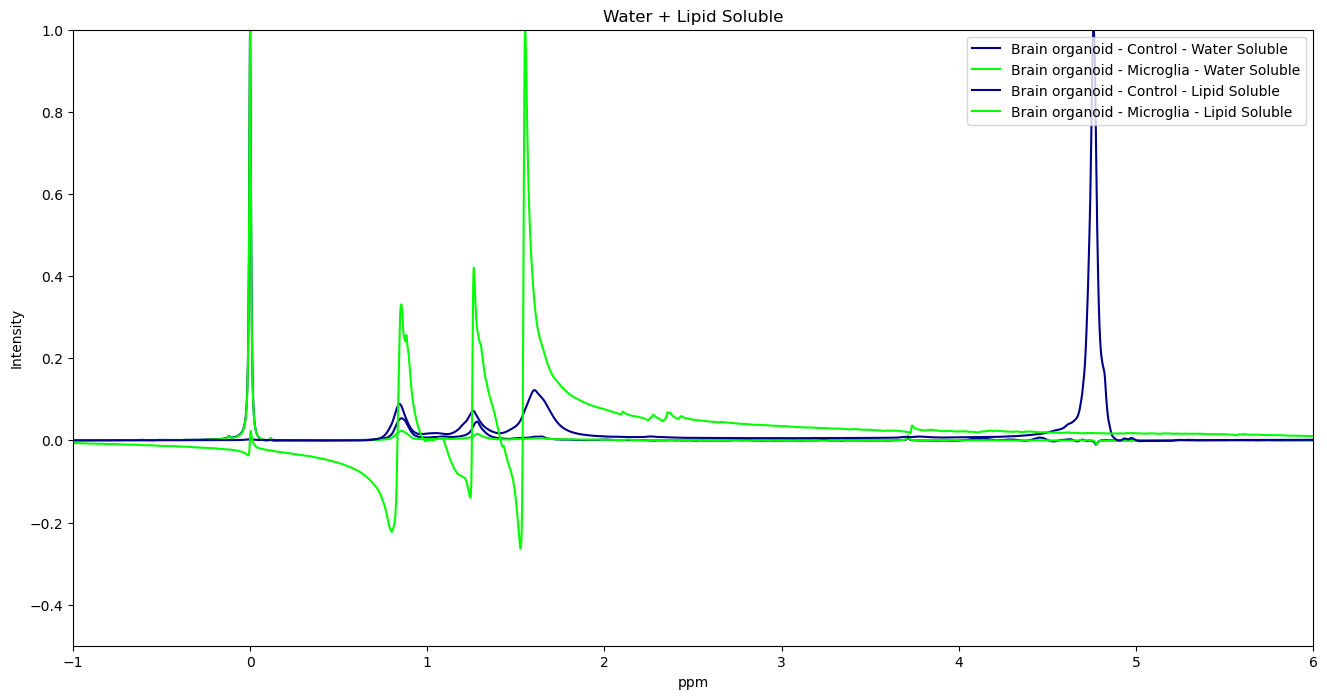

In [21]:
###Water
plt.plot(waterdata['Brain organoid - Control']['ppmSh']['bo_control_water_sample-no2_zgesgp'], 
         waterdata['Brain organoid - Control']['shift']['bo_control_water_sample-no2_zgesgp'], 
         c = "darkblue", label = "Brain organoid - Control")
'''
plt.plot(waterdata['Brain organoid - microglia']['ppmSh']['bo_control_water_sample-no4_zgesgp'], 
         waterdata['Brain organoid - microglia']['shift']['bo_control_water_sample-no4_zgesgp'], 
         c = "lime", label = "Brain organoid - Microglia")
'''
plt.xlim(left = -1, right = 6)
plt.ylim(-0.01, 0.1)
plt.xlabel("ppm")
plt.ylabel("Intensity")
plt.title("Water Soluble")
plt.legend()
plt.show()

plt.plot(waterdata['Brain organoid - microglia']['ppmSh']['bo_control_water_sample-no4_zgesgp'], 
         waterdata['Brain organoid - microglia']['shift']['bo_control_water_sample-no4_zgesgp'], 
         c = "lime", label = "Brain organoid - Microglia")

plt.xlim(left = -1, right = 6)
plt.ylim(-0.01, 0.1)
plt.xlabel("ppm")
plt.ylabel("Intensity")
plt.title("Water Soluble")
plt.legend()
plt.show()


###Lipid
plt.plot(dataDict['Brain organoid - Control']['max_ppms']['bo_control_lipid_sample_no1_day22'], 
         dataDict['Brain organoid - Control']['max_avgs']['bo_control_lipid_sample_no1_day22'], 
         c = "darkblue", label = "Brain organoid - Control")
'''
plt.plot(dataDict['Brain organoid - microglia']['max_ppms']['bo_microglia_lipid_sample_no3'], 
         dataDict['Brain organoid - microglia']['max_avgs']['bo_microglia_lipid_sample_no3'],
         c = "lime", label = "Brain organoid - Microglia")
'''
plt.xlim(left = -1, right = 6)
plt.ylim(-0.5, 1)
#plt.ylim(-0.01, 0.1)
plt.xlabel("ppm")
plt.ylabel("Intensity")
plt.title("Lipid Soluble")
plt.legend(loc = 1)
plt.show()

plt.plot(dataDict['Brain organoid - microglia']['max_ppms']['bo_microglia_lipid_sample_no3'], 
         dataDict['Brain organoid - microglia']['max_avgs']['bo_microglia_lipid_sample_no3'],
         c = "lime", label = "Brain organoid - Microglia")

plt.xlim(left = -1, right = 6)
plt.ylim(-0.5, 1)
#plt.ylim(-0.01, 0.1)
plt.xlabel("ppm")
plt.ylabel("Intensity")
plt.title("Lipid Soluble")
plt.legend(loc = 1)
plt.show()

### Both
plt.figure(figsize=(16,8))
plt.plot(waterdata['Brain organoid - Control']['ppmSh']['bo_control_water_sample-no2_zgesgp'], 
         waterdata['Brain organoid - Control']['shift']['bo_control_water_sample-no2_zgesgp'], 
         c = "darkblue", label = "Brain organoid - Control - Water Soluble")

plt.plot(waterdata['Brain organoid - microglia']['ppmSh']['bo_control_water_sample-no4_zgesgp'], 
         waterdata['Brain organoid - microglia']['shift']['bo_control_water_sample-no4_zgesgp'], 
         c = "lime", label = "Brain organoid - Microglia - Water Soluble")

plt.plot(dataDict['Brain organoid - Control']['max_ppms']['bo_control_lipid_sample_no1_day22'], 
         dataDict['Brain organoid - Control']['max_avgs']['bo_control_lipid_sample_no1_day22'], 
         c = "darkblue", label = "Brain organoid - Control - Lipid Soluble")

plt.plot(dataDict['Brain organoid - microglia']['max_ppms']['bo_microglia_lipid_sample_no3'], 
         dataDict['Brain organoid - microglia']['max_avgs']['bo_microglia_lipid_sample_no3'],
         c = "lime", label = "Brain organoid - Microglia - Lipid Soluble")

plt.xlim(left = -1, right = 6)
plt.ylim(-0.5, 1)
#plt.ylim(-0.01, 0.1)
plt.xlabel("ppm")
plt.ylabel("Intensity")
plt.title("Water + Lipid Soluble")
plt.legend(loc = 1)
plt.show()


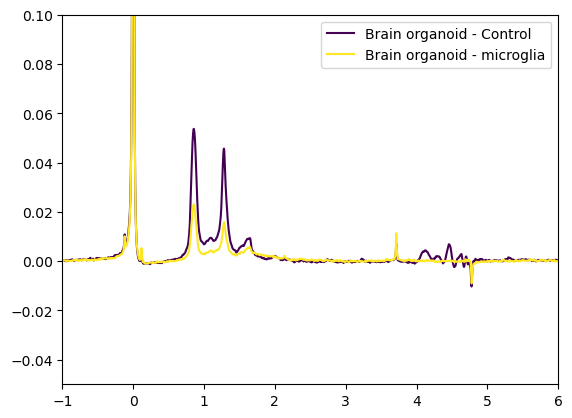

In [32]:
cmap = 'viridis'
map = matplotlib.colormaps[cmap].resampled(2)
counter = 0
for i in dataDict.keys():
    for j in dataDict[i]["shift"].keys():
        if(j.endswith("sgp")):
            plt.plot(dataDict[i]["ppmSh"][j], dataDict[i]["shift"][j],
                     c = map.colors[counter], 
                     label = f"{i}")
            counter += 1
plt.legend()
plt.xlim(left = -1, right = 6)
plt.ylim(-0.05, 0.1)
plt.show()

In [12]:
dataDict["Brain organoid - Control"]

{1: <nmrpy.data_objects.FidArray at 0x155511eeb8d0>,
 'max_avgs': {1: array([-0.00473424, -0.00474382, -0.00475385, ..., -0.0093698 ,
         -0.00936326, -0.00935722])},
 'max_ppms': {1: array([18.05554   , 18.05503932, 18.05453864, ..., -5.74569476,
         -5.74619544, -5.74669612])},
 'shift': {},
 'ppmSh': {}}

In [13]:
truncate_dict(dataDict)

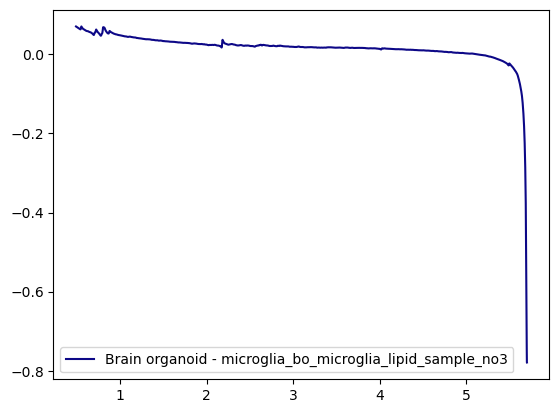

In [14]:
plotTruncdict(dataDict, 4, cmap = 'plasma')

### Perform PCA on truncated Data

In [12]:
from sklearn.decomposition import PCA
import pandas as pd

a = "control"
b = "µglia"

dat = np.array(truncated)
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(dat)
exp = pca.explained_variance_

principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

labels = pd.DataFrame({'label':[a, a, b, b]})

tot = pd.concat([principalDf, labels], axis = 1)
print(tot)

        PC1       PC2    label
0  0.226801 -0.023913  control
1  0.096572  0.037074  control
2 -0.176502  0.003032    µglia
3 -0.146870 -0.016193    µglia


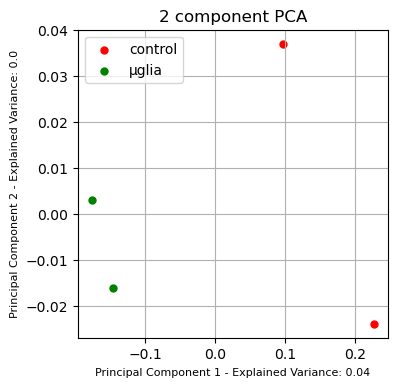

In [19]:
s = 4

fig = plt.figure(figsize = (s,s))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'Principal Component 1 - Explained Variance: {round(exp[0], 2)}', fontsize = 2*s)
ax.set_ylabel(f'Principal Component 2 - Explained Variance: {round(exp[1], 2)}', fontsize = 2*s)
ax.set_title('2 component PCA', fontsize = 3*s)

labels = [a, b]
colors = ['r', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = tot['label'] == label
    ax.scatter(tot.loc[indicesToKeep, 'PC1'], tot.loc[indicesToKeep, 'PC2'], c = color, s = 25)
ax.legend(labels, loc='best')
ax.grid()

### Perform Wavelet Decomposition on processed data

In [20]:
# SWT

def check2(arr):
    n = len(arr)
    counter = 0
    while (n % 2) == 0:
        n //= 2
        counter += 1
    return counter

def padArrs(arr, levels):
    n = len(arr)
    topad = ((n//(2**levels) + 1 ) * (2**levels) - n)
    return np.pad(arr, (0, topad))


def get_region_spec(padded_spectra_list: list):
    n = len(padded_spectra_list)
    out = []
    for i in range(n):
        out.append(region_spec(padded_spectra_list[i]))
    
    return out

def denoise_list(dat:list, lev, w = 'bior2.4', thresh = 'mod', alph = 0):
    flist = get_region_spec(dat)
    waveDict = {}
    n = len(dat)
    for i in range(n):
        dn, cf1, cf2 = wavelet_denoise(level = lev, 
                                       data = dat[i], 
                                       region_spec = flist[i],
                                       wave = w,
                                       threshold = thresh,
                                       alpha = alph)
        waveDict[f"sample_{i+1}"] = {"dn": dn, #denoised spectra
                              "ic": cf1, #initial coefficients
                              "fc": cf2} #final coefficients
    return waveDict


def padtolevel(arr, levels):
    out = []
    if(type(arr) is list):
        n = len(arr)
        for i in range(n):
            if(check2(arr[i]) <= levels):
                write = padArrs(arr[i], levels)
            else:
                write = arr[i]
            out.append(write)

        return out

def wavelet_denoise(level, data, region_spec, wave = 'bior2.4', threshold = 'mod', alpha = 0):
    """
    Stationary wavelet based noise removal technique
    
    Parameters
    ----------
    level : int
        maximum level of the swt to be used for denoising
        typical values range from 5 to 7 for most NMR spectra
    data : ndarray
        real valued spectral data
        best results for unapodized data >16K points
    region_spec : ndarray
        binary spectrum of same length as data used for defining peak regions
    wave : str
        optional : descrete wavelet used for swt
        default : 'bior2.4'
        for a list of other wavelets use command pywt.wavelist(kind='discrete')
    threshold : str
        optional : choice of thresholding method
        default : 'mod'
        'mod' : modified thresholding technique
        'soft' : soft thresholding
        'hard' : hard thresholding
    alpha : float
        optional : alpha value for the modified thresholding
        default  : 1 all values must be >= 0 and <= 1
    
    Returns
    -------
    final : ndarray
        denoised spectrum the same length as the initial data
    coeffin : ndarray
        contains the detail and approximation components prior to thresholding
    coeffs : ndarray
        contains the detail and approximation components after thresholding
    """
    threshlist = ['mod', 'hard', 'soft', 'gar']
    wavelet_list = pywt.wavelist(kind='discrete')
    if threshold not in threshlist:
        raise ValueError("""Threshold method must be 'mod', 'soft', or 'hard'""")
    if wave not in wavelet_list:
        raise ValueError("""Unknown wavelet, please chose from: """, wavelet_list)
    if not 0 <= alpha <= 1:
        raise ValueError('alpha must be >= 0 and <= 1')
    
    coeffs=pywt.swt((data), wave, level = level) #stationary wavelet transform
    coeffin = np.copy(coeffs)
    ### This section calculates the lambdas at each level and removes noise
    ### from each using the chosen thresholding method
    for i in range(len(coeffs)):
        temp = coeffs[i]
        lam = calc_lamb(temp[0], region_spec) #lam comes from approx. component
        if threshold == 'soft':
            fincomp0 = soft_threshold(temp[0], lam)
            fincomp1 = soft_threshold(temp[1], lam)
        if threshold == 'hard':
            fincomp0 = hard_threshold(temp[0], lam)
            fincomp1 = hard_threshold(temp[1], lam)
        if threshold == 'mod':
            fincomp0 = mod_thresh(temp[0], lam, alpha)
            fincomp1 = mod_thresh(temp[1], lam, alpha)
        if threshold == 'gar':
            fincomp0 = gar_threshold(temp[0], lam)
            fincomp1 = gar_threshold(temp[1], lam)
        coeffs[i] = (fincomp0, fincomp1)
    #print('Lambda = %5.3f'%lam)
    final = pywt.iswt(coeffs, wave) #recontrusct the final denoised spectrum
    return final, coeffin, coeffs

def region_spec(data, nthresh = 4.5, buff_size = 200, filter_size = 2):
    """
    Generate a binary spectrum where peak regions = 1 and noise = 0
    
    Parameters
    ----------
    data : ndarray
        real valued spectral data
    nthresh : float
        optional : threshold use to define peak levels
        default  : 4.5 times the noise level
    buff_size : int
        optional : sets the number of points to add around the peaks
        default  : 200 pts
    filter_size : int
        optional : sets the minimum number of points to be considered a peak
        default  : 2 pts
    
    Returns
    -------
    fin_reg : ndarray
        binary spectrum the same length as the initial data defining peak regions
    """
    inp = find_peak_region(data, nthresh=nthresh)
    pidx = peak_indices(inp, buffer_size = buff_size, filter_size = filter_size)
    fin_reg = np.zeros(len(data))
    for i in range(len(pidx)):
        fin_reg[pidx[i,0]:pidx[i,1]] = 1
    return fin_reg

def find_peak_region(signal, thresh = 10, nthresh = 4.5):
    """
    Finds the peaks in the real data
    Follows a hybrid proceedure 
    Uses a moving window approach as used to determine if a region belongs to a peak
    
    Parameters
    ----------
    sign  : ndarray
        derivitive of a FFT NMR data set
    thresh : int
        threshold for gaps in peaks as number of points
        default is 10 pts
    nthresh : float
        threshold use to define peak levels
        default is 4.5 times the noise level
    Returns
    -------
    regions : ndarray
        A binary array where 1 represents a peak region and 0 represents baseline
        
    """
    s0 = np.copy(signal)
    regions = np.zeros(len(s0))
    deriv = base_deriv(s0)
    #determine noise level for thresholding
    sn=np.int64(0); nspts = len(s0) // 16
    tempNoise = np.zeros(16)
    for i in range(16):
        tempNoise[i] = np.std(deriv[sn+(i*nspts):nspts*(i+1)])
    noise = np.min(tempNoise)
    noise *= nthresh
    # use moving window to determine peak regions
    window = np.int64(len(s0)*0.0015)
    regions = np.zeros(len(s0))
    for i in range(window, len(s0)-window):
        minr = np.min(np.abs(deriv[i-window:i+window]))
        maxr = np.max(np.abs(deriv[i-window:i+window]))
        delt = maxr-minr
        if delt > noise:
            regions[i] = 1
    #fill holes in the binary regions array
    for k in range(thresh,len(regions)-thresh):
        pn = regions[k+thresh-1]; nn = regions[k-thresh]
        #look thresh points away from the point of interest to fill holes and remove outliers
        if np.logical_and(regions[k] != pn, regions[k] != nn):
            regions[k] = pn
    return regions

def peak_indices(regions, buffer_size = 200, filter_size = 50):
    """
    Algorithm to transform binary region array into peak region indices
    and to merge and trim peak regions
    
    Parameters
    ----------
    regions : ndarray
        A binary array where 1 represents a peak region and 0 represents baseline
    buffer_size : int
        number of points to add to either side of a peak region
    filter_size : int
        minimum size for a peak region in number of points
    Returns
    -------
    indx : ndarray
        A two by n column matrix defining the start and end of a peak region
    """ 
    init_indx = np.where(regions == 1)[0]
    cons_indx = consecutive(init_indx)
    idx = np.array([]).astype(int)  #empty array for storage
    # loop through the consecutive blocks and find minimum and max values and add buffer points
    for i in range(len(cons_indx)):
        if len(cons_indx[i]) > filter_size:
            idx = np.append(idx, [int(np.min(cons_indx[i])-buffer_size), int(np.max(cons_indx[i])+buffer_size-1)])

    idx = idx.reshape((len(idx)//2, 2))

    # following code determines region overlaps and merges overlaping regions
    n, mn, mx = 1, 0, 0

    for k in range(0, len(idx)):
        if k == 0:
            mn = idx[0,0]
            mx = idx[0,1]
        elif idx[k,0]<=mx:  #there is overlap
            mx = idx[k,1]   #current max is always greater
            n += 1  #increment number in current group
            #print("n=", n, " max=", mx, " min=", mn)
            if k == len(idx)-1:  #last item in the array
                if n>1:
                    for i in range(0, n):  #set all prior items in group
                        idx[k-i, 0] = mn
                        idx[k-i, 1] = mx
        else:  #not overlapping; new group item 1
            if n>1:
                for i in range(1, n+1):  #set all prior items in group
                    idx[k-i, 0] = mn
                    idx[k-i, 1] = mx
            mx = idx[k, 1]
            mn = idx[k, 0]
            n = 1
    idx = np.unique(idx, axis = 0)
    return idx

def base_deriv(s0):
    """
    Function to determine signal derivative
    Uses equation 5 of Zorin et. al. Magn. Reson. Chem. 2017, 55, 738–746
    
    Parameters
    ----------
    s0  : ndarray
        The real component of a FFT array
    Returns
    -------
    deriv : ndarray
        The derivitive of the data, s0
    """
    deriv = np.zeros((len(s0)))
    for i in range(5,len(s0)-5):
        deriv[i] = (42*(s0[i] - s0[i-1]) + 48*(s0[i+1]-s0[i-2]) + 27*(s0[i+2]-s0[i-3]) + 8*(s0[i+3]-s0[i-4]) + s0[i+4]-s0[i-5])/512
    return deriv


def consecutive(data, stepsize=1):
    """"
    basic function to blocks of consecutive number in an array
    """
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def calc_lamb(data, region):
    """calculates the lambda value to use as the noise threshold
    
    Parameters
    ----------
    data: ndarray
        real valued data where the threshold is calculated
    region: ndarry
        binary spectrum that defines the peak and noise regions
        
    Returns
    -------
    lam: float
       value for the noise threshold"""
        
    if type(region) == int:
        if data.ndim == 1:
            noise = data[0:int(0.1*len(data))] 
        elif data.ndim ==2:
            #noise = data[0:int(0.1*len(data[:,0])),0:int(0.2*len(data[0,:]))]
            noise = data[0:int(0.1*len(data[:,0]))] 
    else:
        noise = np.zeros(data.shape)
        idx = np.where(region == 0)
        noise[idx] = data[idx]
            
    sig = np.std(noise)
    lam = sig*np.sqrt(2*np.log(len(data)))
    return lam

def hard_threshold(data, lam):
    """Hard Thresholding"""
    data_thr = np.copy(data)
    neg_idx = np.where(np.abs(data) < lam)
    data_thr[neg_idx] = 0
    return data_thr
    
def soft_threshold(data, lam):
    """Soft Thresholding"""
    data_thr = np.copy(data)
    pos_idx = np.where(data > lam)
    mid_idx = np.where(np.abs(data) <= lam)
    neg_idx = np.where(data < -lam)
    data_thr[pos_idx] = data[pos_idx] - lam
    data_thr[mid_idx] = 0
    data_thr[neg_idx] = data[neg_idx] + lam
    return data_thr

def mod_thresh(data, lam, alpha):
    """Modified thresholding using algorithm in:
    Wang and Dai, Proceedings of the 2018 International Symposium 
    on Communication Engineering & Computer Science (CECS 2018), 2018, 481"""
    data_thr = np.copy(data)
    pos_idx = np.where(np.abs(data) >= lam)
    neg_idx = np.where(np.abs(data) < lam)
    data_thr[pos_idx] = data[pos_idx] - alpha*(lam**4/data[pos_idx]**3)
    data_thr[neg_idx] = (1-alpha)*(data[neg_idx]**5/lam**4)
    return data_thr

def gar_threshold(data, lam):
    "garrote thresholding"
    data_thr = np.copy(data)
    pos_idx = np.where(np.abs(data) > lam)
    neg_idx = np.where(np.abs(data) <= lam)
    data_thr[pos_idx] = data[pos_idx] - lam**2/data_thr[pos_idx]
    data_thr[neg_idx] = 0
    return data_thr

In [21]:
wavedict = denoise_list(dat = padtolevel(truncated, 7), lev = 7)

In [25]:
padded = padtolevel(truncated, 7)

In [26]:
padded

[array([-0.01030708, -0.01009999, -0.00957658, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.01183294, -0.01161739, -0.01105445, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.01066814, -0.01061471, -0.01023336, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.00907747, -0.00901166, -0.0087136 , ...,  0.        ,
         0.        ,  0.        ])]

In [49]:
def calcRMSE(pre, post):
    RMSE = math.sqrt(np.square(np.subtract(post,pre)).mean())
    return RMSE

def addAvgRMSE(dataDict: dict):
    for i in dataDict.keys():
        RMSE = calcRMSE(dataDict[i]['ic'], dataDict[i]['fc'])
        dataDict[i]['avg_RMSE'] = RMSE
        #print(RMSE) 

def addRMSE(dataDict: dict, maxavg):
    for i in dataDict.keys():
        RMSE = calcRMSE(dataDict[i]['dn'], maxavg)
        dataDict[i]['RMSE'] = RMSE
        #print(RMSE)

def addifRMSE(dataDict: dict, maxavg):
    for i in dataDict.keys():
        RMSE1 = calcRMSE(dataDict[i]['ic'], maxavg)
        RMSE2 = calcRMSE(dataDict[i]['fc'], maxavg)
        dataDict[i]['RMSE1'] = RMSE1
        dataDict[i]['RMSE2'] = RMSE2
        #print(RMSE)

def addifRMSELevel(dataDict: dict, maxavg, level):
    for i in dataDict.keys():
        RMSE1 = calcRMSE(dataDict[i]['ic'][level-1], maxavg)
        RMSE2 = calcRMSE(dataDict[i]['fc'][level-1], maxavg)
        dataDict[i]['RMSE1'] = RMSE1
        dataDict[i]['RMSE2'] = RMSE2

def plot_RMSE12Avg(dict, color1 = 'k', color2 = 'white', label = ""):
    x = []
    y1 = []
    y2 = []
    for i in dict.keys():
        x.append(math.log2(i))
        y1.append(dict[i]['RMSE1'])
        y2.append(dict[i]['RMSE2'])
    plt.scatter(x = x, y = y1, color = color1, label = (label + " (no thresh)"))
    plt.scatter(x = x, y = y2, color = color2, label = (label + " (with thresh)"))

def plot_rawAvgRMSE(arr, color = 'gray', label = ""):
    x = []
    y = []
    for i in range(len(arr)):
        RMSE = calcRMSE(arr[i], arr[-1])
        x.append(i)
        y.append(RMSE)
    plt.scatter(x = x, y = y, color = color, label = label)

def plot_avg_RMSE(dict, color = 'k', label = ""):
    x = []
    y = []
    for i,k in enumerate(dict.keys()):
        x.append(i)
        y.append(dict[k]['avg_RMSE'])
    plt.scatter(x = x, y = y, color = color, label = label)

def plot_RMSEbyLvl(dDict: dict, levels: int, cmap = 'viridis', label = ""):
    x = []
    y = []
    c = []
    map = matplotlib.colormaps[cmap].resampled(levels)
    for i, k in enumerate(dDict.keys()):
        for j in range(levels):
            x.append(i)
            y.append(dDict[k][f"lvl{j}_RMSE"])
            c.append(j+1)
    plt.scatter(x = x, y = y, c = c,cmap = map, label = label)

def addRMSEbyLvl(dataDict: dict, levels: int):
    for i in dataDict.keys():
        print(f"{i} Average(s): ")
        for j in range(levels):
            RMSE = calcRMSE(dataDict[i]['ic'][j], dataDict[i]['fc'][j])
            dataDict[i][f"lvl{j}_RMSE"] = RMSE
            print(f"Level: {j+1}, RMSE: {RMSE}")
        print("\n")

#addifRMSELevel(wavedict, maxavg = padded[1], level = 7)

0.00479020040996211
0.003061998647365756
0.001107125840833872
0.004561858067962358


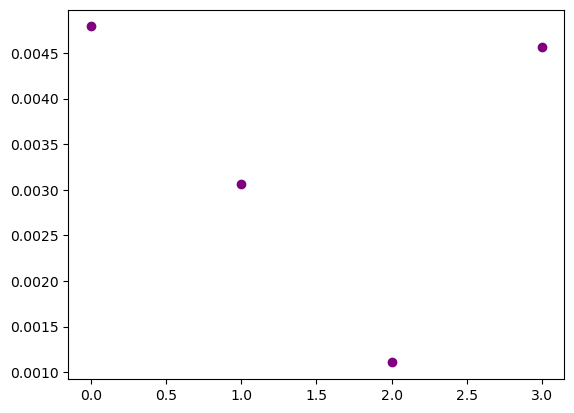

In [40]:
addRMSE(wavedict, maxavg = padded[1])
addAvgRMSE(wavedict)

plot_avg_RMSE(dict = wavedict, color = 'purple', label = "water")

sample_1 Average(s): 
Level: 1, RMSE: 0.00878920010906226
Level: 2, RMSE: 0.007001588457603079
Level: 3, RMSE: 0.004478244430976723
Level: 4, RMSE: 0.0028947392388107445
Level: 5, RMSE: 0.0018478009459154854
Level: 6, RMSE: 0.0012943980038699866
Level: 7, RMSE: 0.0009087559155207869


sample_2 Average(s): 
Level: 1, RMSE: 0.005873908480207597
Level: 2, RMSE: 0.004057736859375931
Level: 3, RMSE: 0.0029001153017175233
Level: 4, RMSE: 0.0019168712456195966
Level: 5, RMSE: 0.0012196741555955913
Level: 6, RMSE: 0.000854793168713636
Level: 7, RMSE: 0.0005995666925777301


sample_3 Average(s): 
Level: 1, RMSE: 0.0015360640657460234
Level: 2, RMSE: 0.0016284095577101148
Level: 3, RMSE: 0.001441976860351758
Level: 4, RMSE: 0.0008672171013295968
Level: 5, RMSE: 0.0006544430629090067
Level: 6, RMSE: 0.00045632751810826264
Level: 7, RMSE: 0.0003177886048553481


sample_4 Average(s): 
Level: 1, RMSE: 0.009055304061040758
Level: 2, RMSE: 0.005847319525807067
Level: 3, RMSE: 0.004032360875407836
Leve

Text(0.5, 1.0, 'RMSE, color corresponds to number of SWT levels')

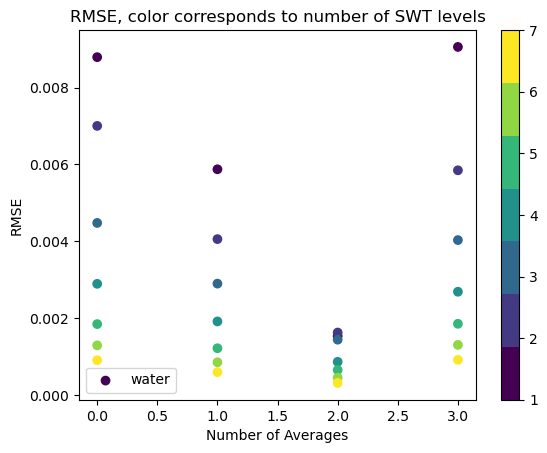

In [51]:
addRMSEbyLvl(wavedict, levels = 7)
plot_RMSEbyLvl(dDict = wavedict, levels = 7, cmap = 'viridis', label = "water")
plt.colorbar()
plt.legend()
plt.xlabel("Number of Averages")
plt.ylabel("RMSE")
plt.title("RMSE, color corresponds to number of SWT levels")